# Import Libraries

In [ ]:
import os
import io
import vertexai
import numpy as np
import pandas as pd
import IPython.display as display
from PIL import Image
from PyPDF2 import PdfReader
from pdf2image import convert_from_path
from google.cloud import storage
from vertexai import rag
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
from vertexai.generative_models import GenerativeModel, Tool
from langchain_google_vertexai import VertexAI, VertexAIEmbeddings

# Preparing credentials

In [4]:
# Define Google Cloud Secret key
SERVICE_ACCOUNT_FILE = "../sparkdatathon-keprof-key.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = SERVICE_ACCOUNT_FILE

# All important parameter and credentials
PROJECT_ID = "sparkdatathon-2025-profess-6"
LOCATION_ID = "us-central1"
storage_client = storage.Client()
bucket_name = "sparkdatathon-keprof-reborn-cloud-storage"
vertexai.init(project=PROJECT_ID, location=LOCATION_ID)

# Image and pdf preparation

In [5]:
# Read the PDF, Convert PDF pages to images
input_pdf_path = "maintenance-guidebook/maintenance-guidebook.pdf"
reader = PdfReader(input_pdf_path)
images = convert_from_path(input_pdf_path)

# Get reference to GCP bucket
bucket = storage_client.bucket(bucket_name)

## Image preparation

In [6]:
# Setup the destination folder inside the cloud storage
destination_folder = "maintenance-image-dataset/"
data = []

# Loop through each page, save as an image, and upload to GCP
for page_number, (page, image) in enumerate(zip(reader.pages, images), start=1):
    # Create a file name for the image
    image_filename = f"maintenance-guidebook-page-{page_number}.jpg"
    
    # Convert image to byte stream
    image_byte_stream = io.BytesIO()
    image.save(image_byte_stream, format="JPEG")
    image_byte_stream.seek(0)

    # Upload to GCP Storage
    blob = bucket.blob(destination_folder + image_filename)
    blob.upload_from_file(image_byte_stream, content_type="image/jpeg")

    print(f"Uploaded {image_filename} to GCP: {blob.public_url}")

print("All images uploaded successfully!")

Uploaded maintenance-guidebook-page-1.jpg to GCP: https://storage.googleapis.com/sparkdatathon-keprof-reborn-cloud-storage/maintenance-image-dataset/maintenance-guidebook-page-1.jpg
Uploaded maintenance-guidebook-page-2.jpg to GCP: https://storage.googleapis.com/sparkdatathon-keprof-reborn-cloud-storage/maintenance-image-dataset/maintenance-guidebook-page-2.jpg
Uploaded maintenance-guidebook-page-3.jpg to GCP: https://storage.googleapis.com/sparkdatathon-keprof-reborn-cloud-storage/maintenance-image-dataset/maintenance-guidebook-page-3.jpg
Uploaded maintenance-guidebook-page-4.jpg to GCP: https://storage.googleapis.com/sparkdatathon-keprof-reborn-cloud-storage/maintenance-image-dataset/maintenance-guidebook-page-4.jpg
Uploaded maintenance-guidebook-page-5.jpg to GCP: https://storage.googleapis.com/sparkdatathon-keprof-reborn-cloud-storage/maintenance-image-dataset/maintenance-guidebook-page-5.jpg
Uploaded maintenance-guidebook-page-6.jpg to GCP: https://storage.googleapis.com/sparkdata

Fetching: maintenance-image-dataset/maintenance-guidebook-page-2.jpg


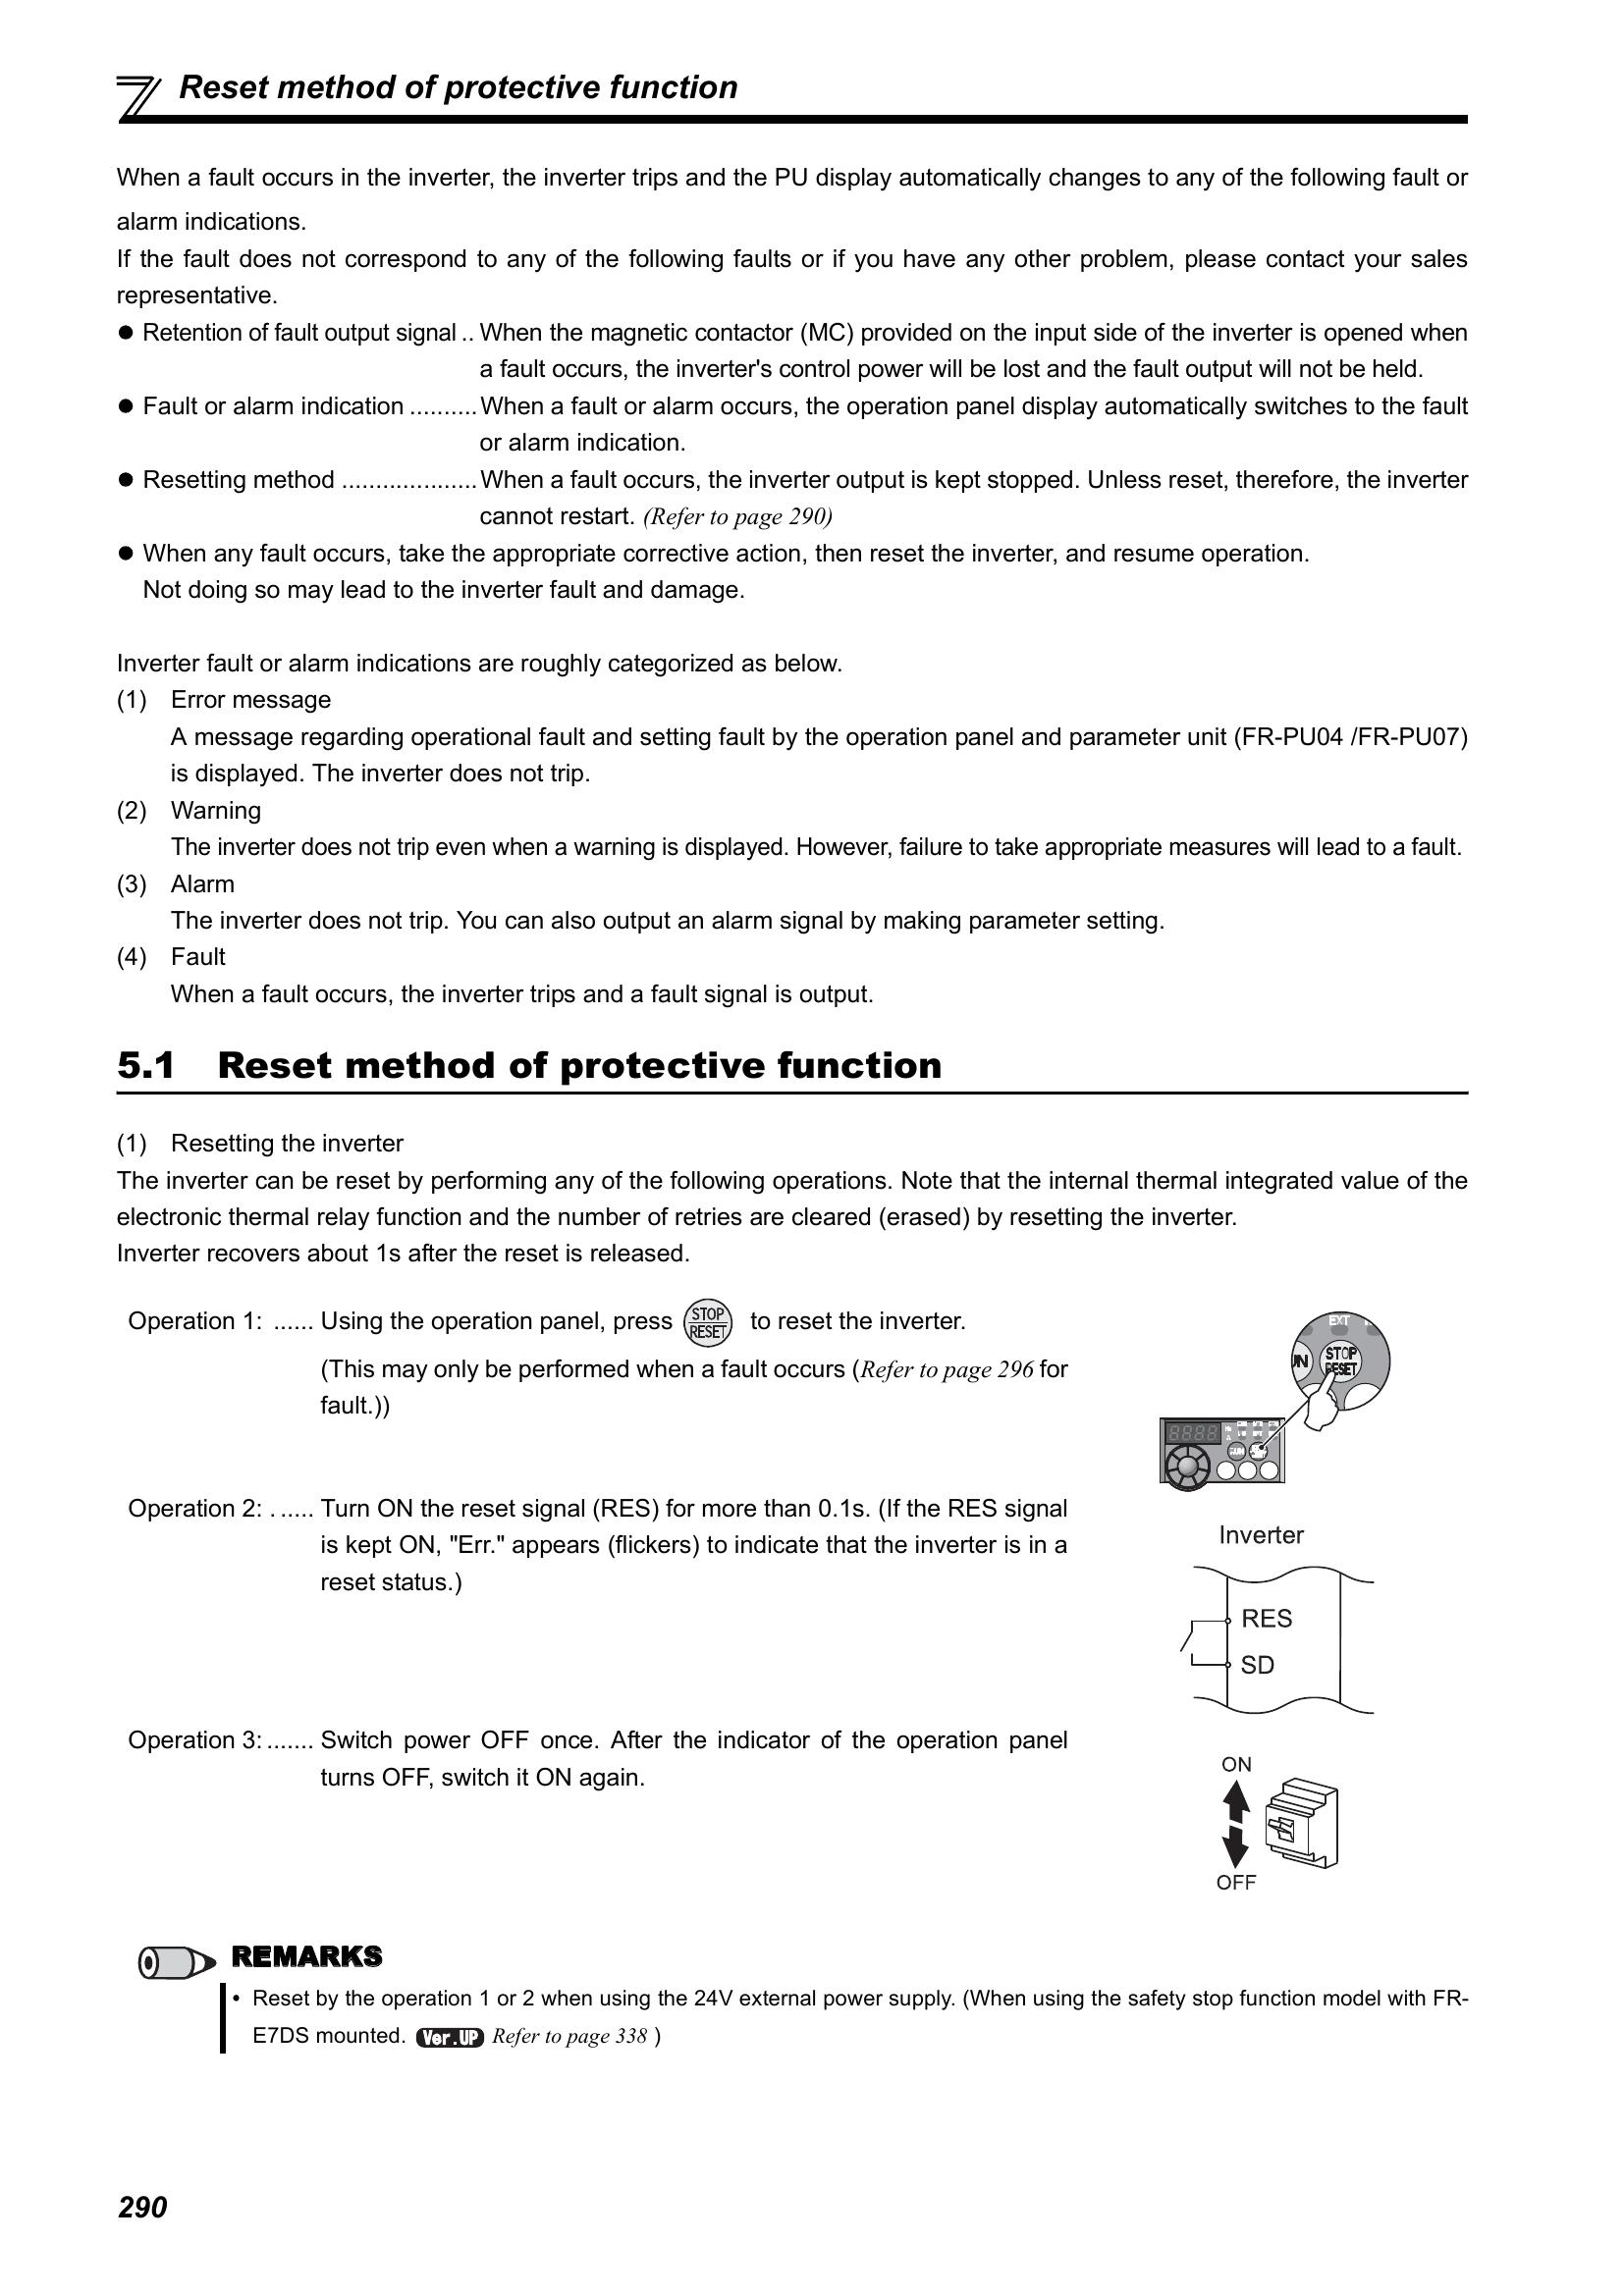

Filtered images processed!


In [7]:
# Testing out code to make the image appeared
image_list = ["maintenance-guidebook-page-2.jpg"]  

# List all files in the destination folder
blobs = bucket.list_blobs(prefix=destination_folder)

for blob in blobs:
    file_name = blob.name.split("/")[-1]  # Extract filename from full path

    if file_name in image_list:  # Check if filename is in the predefined list
        print(f"Fetching: {blob.name}")

        # Download the image as a byte stream
        image_byte_stream = io.BytesIO()
        blob.download_to_file(image_byte_stream)
        image_byte_stream.seek(0)

        # Open the image using PIL
        image = Image.open(image_byte_stream)

        # Display the image (works in Jupyter Notebook)
        display.display(image)

print("Filtered images processed!")

## pdf preparation

In [ ]:
# input for the pdf
destination_folder = "pdf-maintenance-dataset/"
data = []

# Loop through each page, save as an pdf, and upload to GCP
for page_number, (page, image) in enumerate(zip(reader.pages, images), start=1):
    # Create a file name for the pdf
    pdf_filename = f"maintenance-guidebook-page-{page_number}.pdf"
    
    # Convert pdf to byte stream
    pdf_byte_stream = io.BytesIO()
    image.save(pdf_byte_stream, format="pdf")
    pdf_byte_stream.seek(0)

    # Upload to GCP Storage
    blob = bucket.blob(destination_folder + pdf_filename)
    blob.upload_from_file(pdf_byte_stream, content_type="pdf")

    print(f"Uploaded {pdf_filename} to GCP: {blob.public_url}")

print("All pdfs uploaded successfully!")

Uploaded maintenance-guidebook-page-1.pdf to GCP: https://storage.googleapis.com/sparkdatathon-keprof-reborn-cloud-storage/pdf-maintenance-dataset-2/maintenance-guidebook-page-1.pdf
Uploaded maintenance-guidebook-page-2.pdf to GCP: https://storage.googleapis.com/sparkdatathon-keprof-reborn-cloud-storage/pdf-maintenance-dataset-2/maintenance-guidebook-page-2.pdf
Uploaded maintenance-guidebook-page-3.pdf to GCP: https://storage.googleapis.com/sparkdatathon-keprof-reborn-cloud-storage/pdf-maintenance-dataset-2/maintenance-guidebook-page-3.pdf
Uploaded maintenance-guidebook-page-4.pdf to GCP: https://storage.googleapis.com/sparkdatathon-keprof-reborn-cloud-storage/pdf-maintenance-dataset-2/maintenance-guidebook-page-4.pdf
Uploaded maintenance-guidebook-page-5.pdf to GCP: https://storage.googleapis.com/sparkdatathon-keprof-reborn-cloud-storage/pdf-maintenance-dataset-2/maintenance-guidebook-page-5.pdf
Uploaded maintenance-guidebook-page-6.pdf to GCP: https://storage.googleapis.com/sparkdata

# Testing out vertex ai gemini LLM

In [10]:
# Testing out vertex ai gemini
model = GenerativeModel("gemini-1.5-flash")
response = model.generate_content("Do you know who is Joko widodo?")
print(response.text)

Yes, I do! 

**Joko Widodo** is the **7th and current President of Indonesia**. He is often referred to as **Jokowi**. 

Here are some key facts about him:

* **Born:** June 21, 1961, in Surakarta, Central Java, Indonesia
* **Political Career:** 
    * Mayor of Surakarta (2005-2012)
    * Governor of Jakarta (2012-2014)
    * President of Indonesia (2014-present)
* **Political Affiliation:** Indonesian Democratic Party of Struggle (PDIP)
* **Key Policies and Achievements:**
    * Infrastructure development
    * Poverty reduction
    * Healthcare improvement
    * Education reform
* **International Recognition:** 
    * Received numerous awards for his leadership and contributions to Indonesia's development.

Do you have any specific questions about Joko Widodo or his presidency? I'd be happy to provide more information. 



# Create Vertex AI corpus RAG

In [11]:
# Function to list all JSON files in the specified GCS folder
def list_pdf_files(bucket_name, folder_path, storage_client):
    """List down all the pdf files inside a cloud storage"""
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=folder_path)  # List all objects in the folder
    pdf_files = [f"gs://{bucket_name}/{blob.name}" for blob in blobs if blob.name.endswith(".pdf")]
    return pdf_files

def corpus_configuration(embedding_model, display_name): 
    """Corpus creation inside Vertex AI"""

    # corpus configuration
    embedding_model_config = rag.EmbeddingModelConfig(
        publisher_model=f"publishers/google/models/{embedding_model}")
    backend_config = rag.RagVectorDbConfig(rag_embedding_model_config=embedding_model_config)

    # create corpus
    rag.create_corpus(
        display_name=display_name,
        backend_config=backend_config)
    
    print("corpus has been created successfully")

    return None

def corpus_file_import(display_name, paths, corpus_name):
    """Importing maintenance document file into created corpus"""

    transformation_config = rag.TransformationConfig(
        chunking_config=rag.ChunkingConfig(
            chunk_size=None,
            chunk_overlap=None,),)

    rag.import_files(
        corpus_name,
        paths,
        transformation_config=transformation_config,
        max_embedding_requests_per_min=1000)

    print("corpus has been added your documents")

    return None

In [13]:
# Create a RAG Corpus, Import Files, and Generate a response
# TODO(developer): Update and un-comment below lines
display_name = "pdf-maintenance-guidebook-corpus-2"
bucket_name = "sparkdatathon-keprof-reborn-cloud-storage"
folder_path = "pdf-maintenance-dataset-2"
embedding_model = "text-embedding-005"

# Get the list of JSON file paths
paths = list_pdf_files(bucket_name, folder_path, storage_client)
if not paths:
    raise ValueError("No pdf files found in the specified GCS folder.")

# Corpus creation
corpus_creation = corpus_configuration(embedding_model, display_name)

corpus has been created successfully


In [23]:
# List the rag corpus you just created
rag_corpus_list = rag.list_corpora()
rag_corpus_list

ListRagCorporaPager<rag_corpora {
  name: "projects/sparkdatathon-2025-profess-6/locations/us-central1/ragCorpora/5901967311669035008"
  display_name: "pdf-maintenance-guidebook-corpus"
  create_time {
    seconds: 1738309353
    nanos: 830622000
  }
  update_time {
    seconds: 1738309353
    nanos: 830622000
  }
  corpus_status {
    state: ACTIVE
  }
  vector_db_config {
    rag_managed_db {
    }
    rag_embedding_model_config {
      vertex_prediction_endpoint {
        endpoint: "projects/870409621132/locations/us-central1/publishers/google/models/text-embedding-004"
      }
    }
  }
}
>

In [15]:
# Corpus import file
corpus_name = "projects/sparkdatathon-2025-profess-6/locations/us-central1/ragCorpora/5764607523034234880" # you must generate this first
corpus_import_file = corpus_file_import(display_name, paths, corpus_name)

corpus has been added your documents


# Testing out Corpus retrieval

In [ ]:
def corpus_connector(question):

    # List the rag corpus you just created
    corpus_name = "projects/sparkdatathon-2025-profess-6/locations/us-central1/ragCorpora/5764607523034234880"
    
    # Direct context retrieval
    rag_retrieval_config=rag.RagRetrievalConfig(
        top_k=3,  # Optional
        filter=rag.Filter(vector_distance_threshold=0.5))

    response = rag.retrieval_query(
        rag_resources=[rag.RagResource(rag_corpus=corpus_name,)],
        text=question, rag_retrieval_config=rag_retrieval_config,)

    rag_retrieval_tool = Tool.from_retrieval(
    retrieval=rag.Retrieval(
        source=rag.VertexRagStore(
            rag_resources=[
                rag.RagResource(rag_corpus=corpus_name,)]
                ,rag_retrieval_config=rag_retrieval_config,),))
    
    # Create a gemini model instance
    rag_model = GenerativeModel(
        model_name="gemini-1.5-pro-001", tools=[rag_retrieval_tool])

    prompt = f"""
    "Based on the provided document(s), generate a detailed answer to the following question:
{question}

General instruction:
1. The answer must be as detailed as possible, strictly using the information from the given sources.
2. Ensure that the response contains the exact sentences from the document; do not paraphrase or alter the wording.
3. If the source includes bullet points for explanation, retain them as they are to maintain clarity and structure.
4. Do not add any external information or interpretation—stick strictly to the document content.
5. Make sure it is properly structure on the answer"""
    
    # Generate response
    response = rag_model.generate_content(prompt)
    response_text = response.text

    return response_text, response

In [21]:
response_text, response = corpus_connector("please explain to me in detail about Reset method of protective function")
print(response_text)

### Reset method of protective function

When a fault occurs in the inverter, the inverter trips and the PU display automatically changes to any of the fault or alarm indications. When a fault occurs, the inverter output is kept stopped. Unless reset, therefore, the inverter cannot restart. When any fault occurs, take the appropriate corrective action, then reset the inverter, and resume operation. Not doing so may lead to the inverter fault and damage.

The inverter can be reset by performing any of the following operations. Note that the internal thermal integrated value of the electronic thermal relay function and the number of retries are cleared (erased) by resetting the inverter. Inverter recovers about 1s after the reset is released.

*   **Operation 1:**  Using the operation panel, press to reset the inverter. (This may only be performed when a fault occurs) 
*   **Operation 2:** Turn ON the reset signal (RES) for more than 0.1s. (If the RES signal is kept ON, "Err." appears (f

In [22]:
## Delete the selected corpus
rag.delete_corpus("projects/sparkdatathon-2025-profess-6/locations/us-central1/ragCorpora/5764607523034234880")

Successfully deleted the RagCorpus.
